<a href="https://colab.research.google.com/github/yeonghun00/stock-notes/blob/main/analysis/lppl%20model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# LPPL 함수 정의
def lppl_model(t, A, B, C, tc, beta, omega, phi):
    return A + B * np.power(tc - t, beta) + C * np.power(tc - t, beta) * np.cos(omega * np.log(tc - t) + phi)

# 주식 데이터를 가져오는 함수 (예: S&P 500 인덱스)
def get_stock_data(ticker, start_date, end_date):
    df = yf.download(ticker, start=start_date, end=end_date)
    df['Log_Price'] = np.log(df['Close'])
    return df

# 초기 추정치를 계산하는 함수
def calculate_initial_guesses(df):
    log_prices = df['Log_Price']

    # A: 주가의 평균 로그 값
    A = np.mean(log_prices)

    # B: 최근 상승률 (로그 변화율)
    B = (log_prices.iloc[-1] - log_prices.iloc[-30]) / 30
    B = max(B, 0.01)  # B 값을 최소한 0.01 이상으로 설정하여 0으로 수렴하는 것을 방지

    # C: 주가의 변동성 (로그 가격의 표준편차)
    C = np.std(log_prices)
    C = max(C, 0.01)  # C 값을 최소한 0.01 이상으로 설정

    # tc: 데이터의 마지막 시점보다 훨씬 뒤의 시점 (안정성을 위해 더 먼 미래로 설정)
    t_last = len(df)
    tc = t_last + 150

    # beta: 초기 값으로 0.5 설정
    beta = 0.5

    # omega: 주기적인 진동 빈도 (초기 값으로 8 설정)
    omega = 8

    # phi: 초기 위상 (0으로 설정)
    phi = 0

    return A, B, C, tc, beta, omega, phi

# LPPL 모델을 사용하여 주가 데이터를 적합시키는 함수
def fit_lppl_model(df, initial_guess):
    t = np.arange(0, len(df))
    log_prices = df['Log_Price']

    # 비선형 회귀를 사용하여 매개변수 추정 (경계값 설정)
    bounds = ([-np.inf, -np.inf, -np.inf, t[-1], 0, 0, -np.inf],
              [np.inf, np.inf, np.inf, t[-1] + 200, 1, 20, np.inf])

    params, covariance = curve_fit(lppl_model, t, log_prices, p0=initial_guess, bounds=bounds, maxfev=50000)

    return params

# 결과를 시각화하는 함수
def plot_results(df, params, title):
    t = np.arange(0, len(df))
    predicted_prices = lppl_model(t, *params)

    # 거품 지표 계산
    bubble_indicator = np.abs(params[1])  # B 값을 사용하여 거품 강도를 표시

    fig, ax = plt.subplots(2, 1, figsize=(12, 10), gridspec_kw={'height_ratios': [3, 1]})

    # 첫 번째 차트: 실제 가격 vs LPPL 모델 예측
    ax[0].plot(df['Date'], df['Log_Price'], label='Actual Log Price', color='blue')
    ax[0].plot(df['Date'], predicted_prices, label='LPPL Model', linestyle='--', color='orange')

    # 충격 예상 시점을 강조
    tc = params[3]
    shock_date = df['Date'].iloc[int(tc)] if tc < len(df) else df['Date'].iloc[-1] + timedelta(days=tc - len(df))
    ax[0].axvline(shock_date, color='red', linestyle=':', linewidth=2, label=f'Predicted Shock Date: {shock_date.strftime("%Y-%m-%d")}')

    # 충격 강도 계산 및 표시
    shock_strength = abs(params[1])
    ax[0].set_title(f'{title}\nPredicted Shock Strength: {shock_strength:.2f}')

    # 하락 강도 추정 표시
    peak_value = np.exp(max(predicted_prices))
    predicted_drop = peak_value * (1 - shock_strength)
    ax[0].axhline(np.log(predicted_drop), color='purple', linestyle='--', label=f'Predicted Drop: {predicted_drop:.2f}')

    ax[0].set_xlabel('Date')
    ax[0].set_ylabel('Log Price')
    ax[0].legend()
    ax[0].grid(True)

    # 두 번째 차트: 거품 지표
    ax[1].plot(df['Date'], [bubble_indicator] * len(df), label='Bubble Indicator', color='red')
    ax[1].set_ylabel('Bubble Indicator (B)')
    ax[1].set_xlabel('Date')
    ax[1].grid(True)

    plt.tight_layout()
    plt.show()

# 분석 결과를 저장하는 함수
def analyze_period(ticker, start_date, end_date, title):
    df = get_stock_data(ticker, start_date, end_date)
    df.reset_index(inplace=True)
    initial_guess = calculate_initial_guesses(df)
    params = fit_lppl_model(df, initial_guess)
    plot_results(df, params, title)
    return params[3], abs(params[1])


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


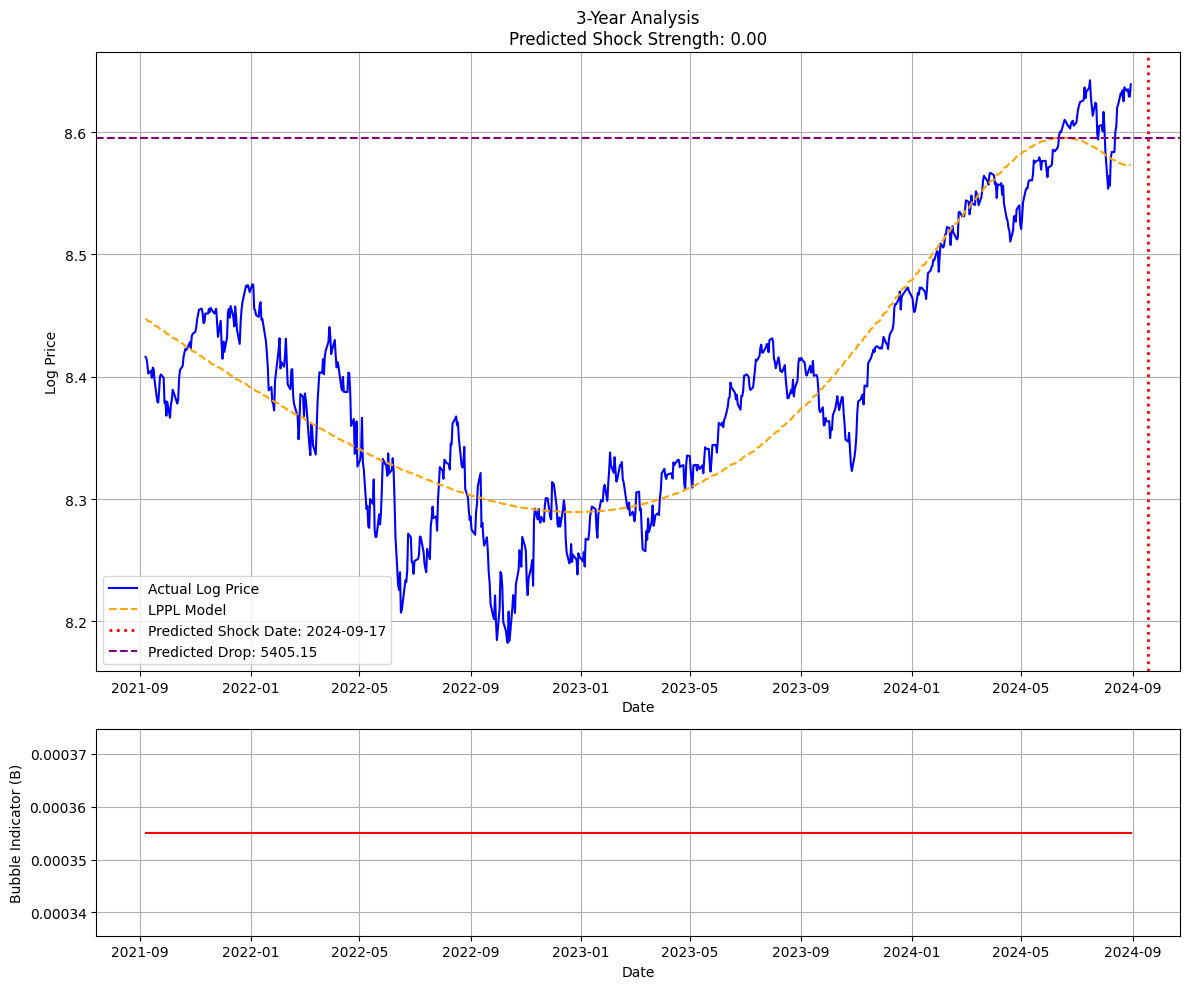

In [38]:
# 3년 분석
ticker = '^GSPC'  # S&P 500 인덱스 심볼
end_date = datetime.today().strftime('%Y-%m-%d')  # 오늘 날짜
start_date_3yr = (datetime.today() - timedelta(days=3*365)).strftime('%Y-%m-%d')  # 3년 전부터

df_3yr = get_stock_data(ticker, start_date_3yr, end_date)
df_3yr.reset_index(inplace=True)
shock_date_3yr, shock_strength_3yr = analyze_period(ticker, start_date_3yr, end_date, '3-Year Analysis')


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


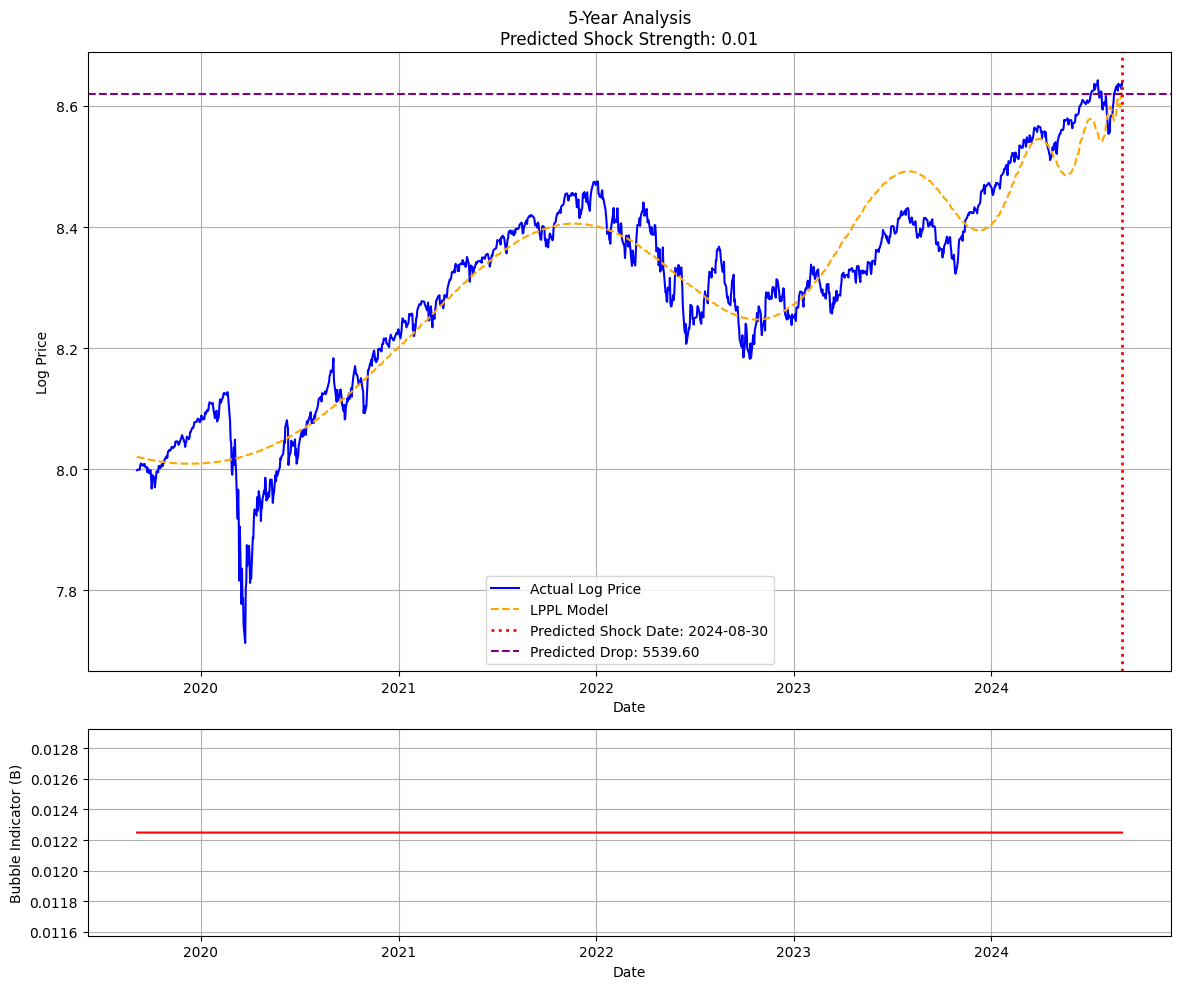

In [39]:
# 5년 분석
start_date_5yr = (datetime.today() - timedelta(days=5*365)).strftime('%Y-%m-%d')  # 5년 전부터

df_5yr = get_stock_data(ticker, start_date_5yr, end_date)
df_5yr.reset_index(inplace=True)
shock_date_5yr, shock_strength_5yr = analyze_period(ticker, start_date_5yr, end_date, '5-Year Analysis')


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


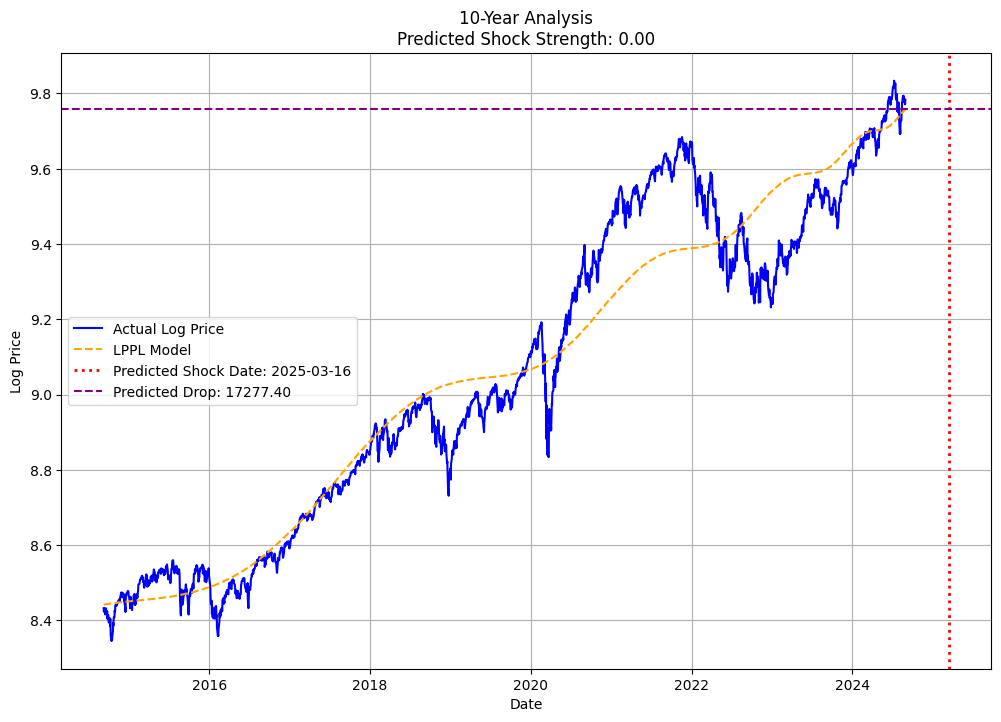

In [35]:
# 10년 분석
start_date_10yr = (datetime.today() - timedelta(days=10*365)).strftime('%Y-%m-%d')  # 10년 전부터

df_10yr = get_stock_data(ticker, start_date_10yr, end_date)
df_10yr.reset_index(inplace=True)  # 인덱스를 재설정하여 'Date' 열을 추가
shock_date_10yr, shock_strength_10yr = analyze_period(ticker, start_date_10yr, end_date, '10-Year Analysis')


In [36]:
# 평균 충격 시점 및 강도 계산
average_tc = np.mean([shock_date_3yr, shock_date_5yr, shock_date_10yr])
average_strength = np.mean([shock_strength_3yr, shock_strength_5yr, shock_strength_10yr])

# 충격 날짜를 3년 데이터프레임 기준으로 변환 (3년, 5년, 10년 분석에서 사용된 데이터가 다를 수 있지만, 충격 시점을 계산하는 데 하나를 기준으로 사용)
average_shock_date = df_3yr['Date'].iloc[int(average_tc)] if average_tc < len(df_3yr) else df_3yr['Date'].iloc[-1] + timedelta(days=average_tc - len(df_3yr))

# 결과 출력
print(f'Average Predicted Shock Date: {average_shock_date.strftime("%Y-%m-%d")}')
print(f'Average Predicted Shock Strength: {average_strength:.2f}')


Average Predicted Shock Date: 2026-12-06
Average Predicted Shock Strength: 0.00


[*********************100%***********************]  1 of 1 completed


Fitted parameters:
A = 231.13751827899122
B = -0.11580762637767364
C = 0.055372553776521796
tc = 181.51043623930104
m = 1.269079232723868
omega = 4.913392891144078
phi = 5.883545660583333


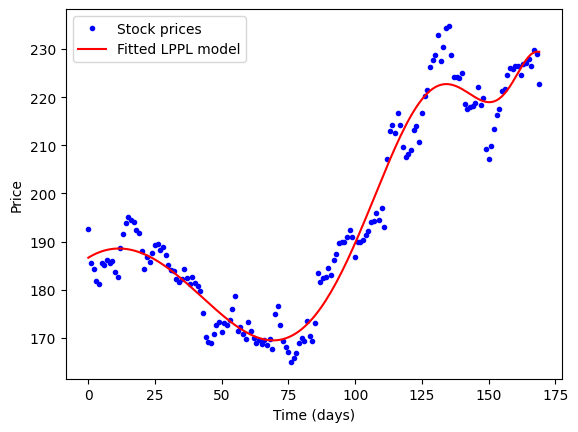

array([ 2.31137518e+02, -1.15807626e-01,  5.53725538e-02,  1.81510436e+02,
        1.26907923e+00,  4.91339289e+00,  5.88354566e+00])

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import yfinance as yf
from datetime import datetime, timedelta

# LPPL 모델 함수 정의
def lppl_model(t, A, B, C, tc, m, omega, phi):
    return A + B * (tc - t)**m + C * (tc - t)**m * np.cos(omega * np.log(tc - t) + phi)

# Yahoo Finance에서 데이터 가져오기
def get_stock_data(ticker, period):
    end_date = datetime.today()
    start_date = end_date - timedelta(days=period)
    data = yf.download(ticker, start=start_date, end=end_date)
    return data['Close']

# LPPL 모델 피팅 함수
def fit_lppl(ticker, period):
    prices = get_stock_data(ticker, period)
    t = np.arange(len(prices))

    # 초기 파라미터 추정값
    initial_guess = [max(prices), -1, 0.5, len(prices) + 50, 0.5, 6, 0]

    # 파라미터 피팅
    popt, pcov = curve_fit(lppl_model, t, prices, p0=initial_guess, maxfev=20000)

    # 피팅된 파라미터 출력
    A_fit, B_fit, C_fit, tc_fit, m_fit, omega_fit, phi_fit = popt
    print("Fitted parameters:")
    print(f"A = {A_fit}")
    print(f"B = {B_fit}")
    print(f"C = {C_fit}")
    print(f"tc = {tc_fit}")
    print(f"m = {m_fit}")
    print(f"omega = {omega_fit}")
    print(f"phi = {phi_fit}")

    # 피팅 결과 시각화
    plt.plot(t, prices, 'b.', label='Stock prices')
    plt.plot(t, lppl_model(t, *popt), 'r-', label='Fitted LPPL model')
    plt.xlabel('Time (days)')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

    return popt

# 사용 예시
ticker = 'AAPL'  # 원하는 주식 티커
period = 250     # 125~750일 사이의 기간, 여기서는 250일 예시
fit_lppl(ticker, period)


In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import yfinance as yf
from datetime import datetime, timedelta

# LPPL 모델 함수 정의
def lppl_model(t, A, B, C, tc, m, omega, phi):
    return A + B * (tc - t)**m + C * (tc - t)**m * np.cos(omega * np.log(tc - t) + phi)

# Yahoo Finance에서 데이터 가져오기
def get_stock_data(ticker, period):
    end_date = datetime.today() - timedelta(days=5757)
    start_date = end_date - timedelta(days=period)
    data = yf.download(ticker, start=start_date, end=end_date)
    return data['Close']

# 특정 기간에 대해 LPPL 모델 피팅 함수
def fit_lppl_model(prices):
    t = np.arange(len(prices))
    initial_guess = [max(prices), -1, 0.5, len(prices) + 50, 0.5, 6, 0]
    try:
        popt, _ = curve_fit(lppl_model, t, prices, p0=initial_guess, maxfev=20000)
        tc_fit = popt[3]
        return popt, tc_fit
    except RuntimeError:
        return None, None

# LPPLS Singularity Confidence Indicator 계산 함수
def calculate_lppls_singularity(ticker, min_period=125, max_period=750, step=20):
    prices = get_stock_data(ticker, max_period)
    n = len(prices)
    bubble_count = 0
    total_windows = 0

    # 각 윈도우에 대해 LPPL 모델 피팅
    for window_size in range(min_period, max_period + 1, step):
        for start in range(0, n - window_size + 1, step):
            end = start + window_size
            window_prices = prices[start:end]
            popt, tc_fit = fit_lppl_model(window_prices)
            if popt is not None:
                # 버블 감지: tc가 데이터 범위 내에 존재할 때 버블로 간주
                if 0 < tc_fit < window_size:
                    bubble_count += 1
            total_windows += 1

    # Singularity Confidence Indicator 계산
    bubble_ratio = bubble_count / total_windows
    print(f"Bubble ratio: {bubble_ratio * 100:.2f}%")

    if bubble_ratio >= 0.1:
        print("This stock/market index is in a bubble according to LPPLS Singularity Confidence Indicator.")
    else:
        print("This stock/market index is not in a bubble according to LPPLS Singularity Confidence Indicator.")

    return bubble_ratio

# 사용 예시
ticker = '^KS11'  # 원하는 주식 티커
calculate_lppls_singularity(ticker)


[*********************100%***********************]  1 of 1 completed
<ipython-input-19-14682a09a076>:9: RuntimeWarning: invalid value encountered in power
  return A + B * (tc - t)**m + C * (tc - t)**m * np.cos(omega * np.log(tc - t) + phi)
<ipython-input-19-14682a09a076>:9: RuntimeWarning: invalid value encountered in log
  return A + B * (tc - t)**m + C * (tc - t)**m * np.cos(omega * np.log(tc - t) + phi)
<ipython-input-19-14682a09a076>:23: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(lppl_model, t, prices, p0=initial_guess, maxfev=20000)


Bubble ratio: 14.76%
This stock/market index is in a bubble according to LPPLS Singularity Confidence Indicator.


0.14761904761904762

In [ ]:
18.095